In [1]:
from osgeo import gdal
import numpy as np
import pandas as pd
import os
#import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../Functions')
import TiffTools as tt

%load_ext autoreload
%autoreload 2

In [46]:
inlist = []
directory = '/Users/chanagan/Desktop/GarlockClip'
for folder in os.listdir(directory):
    if folder.startswith('m_'):
        print(folder)
        for file in os.listdir(f'{directory}/{folder}/'):
            if file.endswith('.tif'):
                print(file)
                path = directory+'/'+folder+'/'
                inlist.append(path+file)


m_3511729_se_11_060_20200515
m_3511729_se_11_060_20200515.tif
m_3511729_se_11_060_20180818
m_3511729_se_11_060_20180818.tif


In [47]:
clipArea = '/Users/chanagan/Desktop/GarlockClip/shapes/GarlockClip.shp'

In [50]:
outf = 'mm2018garlock.tif'
inf = inlist[1]

# Create Greyscale image at 60 cm resolution cut to AOI
tt.micmacExport(inf,outname=outf,srs='EPSG:32610',interp='cubic',cutlineDSName=clipArea,
                outres=[0.6,-0.6])

outf = 'mm2020garlock.tif'
inf = inlist[0]

# Create Greyscale image at 60 cm resolution cut to AOI
tt.micmacExport(inf,outname=outf,srs='EPSG:32610',interp='cubic',cutlineDSName=clipArea,
                outres=[0.6,-0.6])


Computing Gray from RGB values
Writing to mm2018garlock.tif
Computing Gray from RGB values
Writing to mm2020garlock.tif


(None,
 array([[170.2729, 170.692 , 155.5857, ..., 158.9042, 156.9044, 151.8017],
        [171.9199, 169.3331, 144.5698, ..., 156.6764, 158.0892, 157.2033],
        [171.3329, 169.9201, 160.0737, ..., 147.7312, 150.318 , 155.8614],
        ...,
        [150.58  , 147.9053, 136.401 , ..., 125.8321, 128.2879, 124.1034],
        [148.4708, 144.2324, 139.1081, ..., 122.2238, 125.3375, 124.0603],
        [141.6286, 136.7   , 144.14  , ..., 125.4623, 126.473 , 122.6906]]))

# MicMac Run and Results


In [54]:
im1f = '/Users/chanagan/Desktop/GarlockClip/MicMacGarlock/mm2018garlock.tif'
im2f = '/Users/chanagan/Desktop/GarlockClip/MicMacGarlock/mm2020garlock.tif'

In [55]:
# Example of creating a run file, thank you Solene for the help!
tt.createMicmacParamFile(im1f,im2f,folder='./',SzW=2,CorMin=0.5,SrchW=5)

'./ param_LeChantier_Compl.xml written.'

In [59]:
folder[:-3]+'mm2020garlock.tif'

'/Users/chanagan/Desktop/GarlockClip/MicMacGarlock/Mmm2020garlock.tif'

In [61]:
# Projected displacements
azimuth = 254
folder = '/Users/chanagan/Desktop/GarlockClip/MicMacGarlock/MEC/'

tt.micmacPostProcessing(folder=folder,
                         prefile=folder[:-4]+'mm2020garlock.tif',
                        outprefix=folder)

cor = gdal.Open(folder+'Correlmicmac.tif')
mask = (cor.GetRasterBand(1).ReadAsArray() > 0.5)
ewtif = folder+'EWmicmac.tif'
nstif = folder+'NSmicmac.tif'
print('Working in',folder)
par, perp = tt.projectDisp(ewtif,nstif,azimuth,mask=None,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')

Saving /Users/chanagan/Desktop/GarlockClip/MicMacGarlock/MEC/NSmicmac.tif
Saving /Users/chanagan/Desktop/GarlockClip/MicMacGarlock/MEC/EWmicmac.tif
Saving /Users/chanagan/Desktop/GarlockClip/MicMacGarlock/MEC/Correlmicmac.tif
Working in /Users/chanagan/Desktop/GarlockClip/MicMacGarlock/MEC/


In [70]:
curl = tt.curl_2d(par,perp)
nodata_mask = (par != -999)
curl[~nodata_mask] = -999

tt.save_geotiff(curl,folder+'curl.tif',cor.GetGeoTransform(),cor.GetProjection(),nodata=-999)

## Filter the images

In [2]:
from sklearn.decomposition import FastICA

In [30]:
imfpar = './ParallelDispCorrWeightedPerYearNo2016_2018.tif'
imds_par = gdal.Open(imf)
imfpar = './PerpendicularDispCorrWeightedPerYearNo2016_2018.tif'
imds_perp = gdal.Open(imf)

nodatamask = (imds_par.GetRasterBand(1).ReadAsArray() != imds_par.GetRasterBand(1).GetNoDataValue())


In [31]:
disp_par = imds_par.GetRasterBand(1).ReadAsArray()
disp_perp = imds_perp.GetRasterBand(1).ReadAsArray()


In [36]:
curl = curl_2d(disp_perp,disp_par)
curl[~nodatamask] = -999

In [46]:
tt.save_geotiff(curl,'CurlCorrWeightedPerYearNo2016_2018.tif',imds_par.GetGeoTransform(),imds_par.GetProjection(),nodata=-999)

array([ 4.99515606e+02,  1.99674460e-04,  1.38412933e-04, ...,
        4.93697386e-05, -1.40565707e-04, -4.99501017e+02])

In [83]:
tt.micmacExport('/Users/chanagan/Desktop/QuakesOrtho/MicMacTest/2007_aligned.tif',
                outname='/Users/chanagan/Desktop/QuakesOrtho/MicMacTest/mm2007.tif', srs='EPSG:32610', 
                outres=[1,-1],interp='cubic', a_ullr=[699207.2,4007049.6,702605.0,4005039.4])

Computing Gray from RGB values
Writing to /Users/chanagan/Desktop/QuakesOrtho/MicMacTest/mm2007.tif


In [84]:
tt.micmacExport('/Users/chanagan/Desktop/QuakesOrtho/area1_agisoft_orthomosaic/lewis_creek_area_orthophoto_1m_WGS84.tif',              
               outname='/Users/chanagan/Desktop/QuakesOrtho/MicMacTest/mmQuakes.tif', srs='EPSG:32610', 
                outres=[1,-1],interp='cubic', a_ullr=[699207.2,4007049.6,702605.0,4005039.4])

Computing Gray from RGB values
Writing to /Users/chanagan/Desktop/QuakesOrtho/MicMacTest/mmQuakes.tif


In [85]:
tt.createMicmacParamFile('mm2007.tif','mmQuakes.tif',folder='./',SzW=15,CorMin=0.5,SrchW=20)

'./ param_LeChantier_Compl.xml written.'

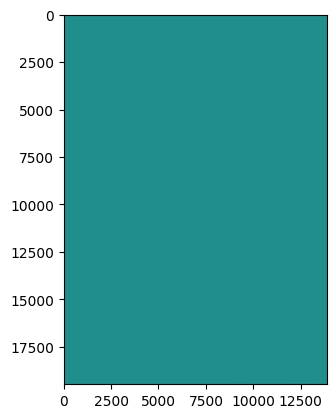

In [38]:
plt.close()
plt.imshow(curl)
plt.show()

In [ ]:
folders = ['/Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2016/',
           '/Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2018/',
           '/Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2020/',
           '/Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2022/']
folders = ['/Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2016_2022/']

In [11]:
# Add all of the tifs together
baseim = gdal.Open(folders[0]+'ParallelDisp.tif')
nodatamask = (baseim.GetRasterBand(1).ReadAsArray() != baseim.GetRasterBand(1).GetNoDataValue())

disp = np.zeros((np.shape(nodatamask)[0],np.shape(nodatamask)[1],len(folders)))
disp[:,:,0] = baseim.GetRasterBand(1).ReadAsArray()
for i,folder in enumerate(folders[1:]):
    im = gdal.Open(folder+'ParallelDisp.tif')
    arr = im.GetRasterBand(1).ReadAsArray()
    disp[:,:,i+1] = arr
    print('Adding displacements from',folder)

Adding displacements from /Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2018/
Adding displacements from /Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2020/
Adding displacements from /Volumes/Extreme Pro/Data/MicMac/MRMR/MEC2007_2022/


In [54]:
# Assuming 'image_array' is your 2D image array
# Reshape the 2D image array into a 1D array
nrows = np.shape(disp[:,:,0][10000:15000,4500:10500])[0]
ncols = np.shape(disp[:,:,0][10000:15000,4500:10500])[1]
flattened_image = disp[10000:15000,4500:10500,:].reshape(nrows*ncols,len(folders)) #disp.reshape(len(folders),nrows*ncols) # Reshape to column vector



In [67]:
# Apply ICA to the flattened image array
n=3
ica = FastICA(n_components=4, random_state=42,tol=0.1,max_iter=400,whiten='arbitrary-variance',whiten_solver='eigh')
ica_components = ica.fit_transform(flattened_image)  
ica_recovered = ica_components.reshape(nrows, ncols,3) # Reshape to images


ValueError: cannot reshape array of size 120000000 into shape (5000,6000,3)

In [64]:
for i in range(0,4):
    ica_recovered[:,:,i][~nodatamask[10000:15000,4500:10500]] = -999
    tt.save_geotiff(ica_recovered[:,:,i],f'IC{i}.tif',baseim.GetGeoTransform(),baseim.GetProjection())

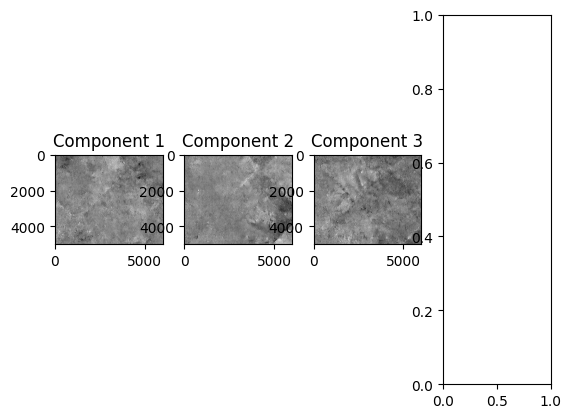

In [65]:
# Visualize the independent components
fig, axes = plt.subplots(1, 4)
for i in range(3):
    axes[i].imshow(ica_recovered[:, :, i], cmap='gray')
    axes[i].set_title(f'Component {i+1}')
plt.show()

In [29]:
# Import ZCA, ICA, numpy, input output functions, and visualization functions
import numpy as numx
from pydeep.preprocessing import ICA, ZCA
import pydeep.misc.io as io
import pydeep.misc.visualization as vis

/Users/chanagan/miniconda3/envs/asp/lib/python3.9/site-packages/PyDeep-1.2.0-py3.9.egg/pydeep/misc/io.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/chanagan/miniconda3/envs/asp/lib/python3.9/site-packages/PyDeep-1.2.0-py3.9.egg/pydeep/misc/io.py:417: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/chanagan/miniconda3/envs/asp/lib/python3.9/site-packages/PyDeep-1.2.0-py3.9.egg/pydeep/misc/visualization.py:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/chanagan/miniconda3/envs/asp/lib/python3.9/site-packages/PyDeep-1.2.0-py3.9.egg/pydeep/misc/visualization.py:252: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/chanagan/miniconda3/envs/asp/lib/python3.9/site-packages/PyDeep-1.2.0-py3.9.egg/pydeep/misc/visualization.py:345: SyntaxWarning: "is" with a literal. Did you mean "=="?
/Users/chanagan/miniconda3/envs/asp/lib/python3.9/site-packages/PyDeep-1.2.0-py3.9.egg/pydeep/misc/visualization.py:347: SyntaxWarning: "is" w

In [7]:
pwd

'/Users/chanagan/Gitcode/ImageryResources/Notebooks'

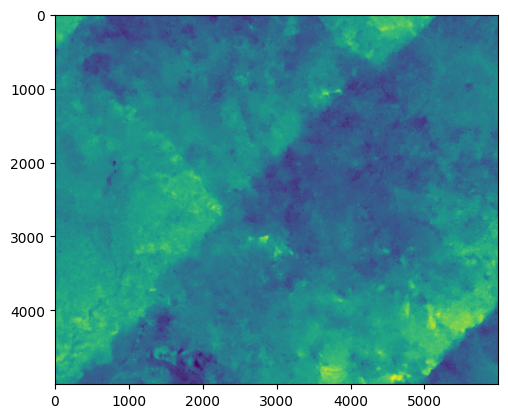

In [46]:
plt.imshow(disp[:,:,0][10000:15000,4500:10500])

In [48]:
nrows

19478

In [50]:
# Load data (download is not existing)
nrows = np.shape(disp[:,:,0][10000:15000,4500:10500])[0]
ncols = np.shape(disp[:,:,0][10000:15000,4500:10500])[1]
flattened_image = disp[10000:15000,4500:10500,:].reshape(len(folders),nrows*ncols) #disp.reshape(len(folders),nrows*ncols) # Reshape to column vector

data = flattened_image

In [34]:
np.shape(pardisp)

NameError: name 'pardisp' is not defined

In [51]:


# Specify image width and height for displaying
width = ncols
height = nrows

# Use ZCA to whiten the data and train it
# (you could also use PCA whitened=True + unproject for visualization)
zca = ZCA(input_dim=width * height)
zca.train(data=data)

# ZCA projects the whitened data back to the original space, thus does not
# perform a dimensionality reduction but a whitening in the original space
whitened_data = zca.project(data)

# Create a ZCA node and train it (you could also use PCA whitened=True)
ica = ICA(input_dim=width * height)
ica.train(data=whitened_data,
          iterations=100,
          convergence=1.0,
          status=True)

# Show whitened images
images = vis.tile_matrix_rows(matrix=data[0:100].T,
                              tile_width=width,
                              tile_height=height,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches')

# Show some whitened images
images = vis.tile_matrix_rows(matrix=whitened_data[0:100].T,
                              tile_width=width,
                              tile_height=height,
                              num_tiles_x=10,
                              num_tiles_y=10,
                              border_size=1,
                              normalized=True)
vis.imshow_matrix(matrix=images,
                  windowtitle='First 100 image patches whitened')

# Show the ICA filters/bases
ica_filters = vis.tile_matrix_rows(matrix=ica.projection_matrix,
                                   tile_width=width,
                                   tile_height=height,
                                   num_tiles_x=width,
                                   num_tiles_y=height,
                                   border_size=1,
                                   normalized=True)
vis.imshow_matrix(matrix=ica_filters,
                  windowtitle='Filters learned by ICA')

# Get the optimal gabor wavelet frequency and angle for the filters
opt_frq, opt_ang = vis.filter_frequency_and_angle(ica.projection_matrix,
                                                  num_of_angles=40)

# Show some tuning curves
num_filters = 20
vis.imshow_filter_tuning_curve(ica.projection_matrix[:,0:num_filters],
                               num_of_ang=40)

# Show some optima grating
vis.imshow_filter_optimal_gratings(ica.projection_matrix[:,0:num_filters],
                                   opt_frq[0:num_filters],
                                   opt_ang[0:num_filters])

# Show histograms of frequencies and angles.
vis.imshow_filter_frequency_angle_histogram(opt_frq=opt_frq,
                                            opt_ang=opt_ang,
                                            max_wavelength=14)

print("log-likelihood on all data: "+str(numx.mean(
    ica.log_likelihood(data=whitened_data))))

# Show all windows.
vis.show()

MemoryError: Unable to allocate 6.39 PiB for an array with shape (30000000, 30000000) and data type float64

In [ ]:
## THIS TAKES ABOUT 45 SECONDS FOR A SMALL SCENE (2 tiles merged). Plotting takes a lot of the time
## It takes ~25 min to run for all the scenes, with plotting

rasterpath = '/Users/nreitman/Library/CloudStorage/OneDrive-DOI/Projects/2023-02-06 Turkey/micmac/planet/final_files_999'

# projnames = ['cardak1','cardak2A','cardak2B','cardak3','cardak4','cardak5','cardak5A']
projnames = ['eaf_fieldarea', 'eaf_hatay','eaf_islahiye','eaf_islahiyewest','eaf_northA','eaf_northB',
             'eaf_southgolbasi','eaf_southnarli','cardak1','cardak2A','cardak2B','cardak3','cardak4','cardak5','cardak5A']

for projname in (projnames):
    print(projname)
    origfile = 'final_%s_Px2_Num5_DeZoom1_LeChantier_clip.tif' %projname ## ONLY DOES PX1 or PX2, not both
    raster = rxr.open_rasterio(os.path.join(rasterpath,origfile),masked=True).squeeze() #faster way to open, but not with metadata needed for export

    # get metadata from original raster (using raster data from this read in method is slower than above)
    with rio.open(os.path.join(rasterpath,origfile)) as src:
        delete = src.read()
        metadata = src.profile
    src.close()

    # set angle to make stripes horizontal
    angle = 14 # angle of stripes in degrees. started with 14, tested 13.5 and 14.7. 14 better than 13.5 and 14.7

    # rotate raster by angle to make stripes horizontal for easier data handling
    raster_rotate = ndimage.rotate(raster, angle, reshape=True, order=1, cval=np.nan) # order resolves over-interpretation leaving no weird values. cval fills empty cells with nan

    # get the average value of each row and save to a "stripes" raster
    stripes = np.zeros(np.shape(raster_rotate),dtype=float)
    for j in range(len(raster_rotate[:,0])): # indexing is [row,column], so this is iterate through all rows, first column
            stripes[j] = np.nanmean(raster_rotate[j,:]) # for each row, take the mean of all column values

    # subtract stripes from raster_rotate
    destripe_rotate = raster_rotate - stripes

    # rotate destripe back to original orientation
    destripe = ndimage.rotate(destripe_rotate, -angle, reshape=True, order=1,cval=np.nan)

    ## clip off all rows & columns of all np.nan in destripe raster to keep it the size of original raster
    destripe = destripe[~np.isnan(destripe).all(axis=1),:] # get rid of all rows that are all nan 
    destripe = destripe[:,~np.isnan(destripe).all(axis=0)] # get rid of all columns that are all nan

    ## save destripe raster to file
    newfile = 'destripe/destripe_%s_'%angle+origfile
    with rio.open(os.path.join(rasterpath,newfile), 'w', **metadata) as dst:
        dst.write(destripe, 1)

In [ ]:
# ## show intermediate steps
    # plt.imshow(stripes,cmap='PuOr',vmin=-10,vmax=10)
    # plt.show()
    # plt.imshow(destripe_rotate,cmap='PuOr',vmin=-10,vmax=10)
    # plt.show()


    # plot original and destripe rasters
    fig = plt.subplots(1,2,figsize=(8,5))

    ## original
    plt.subplot(1,2,1)
    plt.suptitle(projname)
    plt.title('original')
    plt.imshow(raster,cmap='PuOr',vmin=-10,vmax=10)
    #plt.imshow(raster_rotate,cmap='PuOr',vmin=-10,vmax=10)

    ## destripe
    plt.subplot(1,2,2)
    plt.title('destripe')
    #plt.imshow(raster_rotate,cmap='PuOr',vmin=-10,vmax=10)
    #plt.imshow(stripes,cmap='PuOr',vmin=-10,vmax=10)
    #plt.imshow(destripe_rotate,cmap='PuOr',vmin=-10,vmax=10)
    plt.imshow(destripe,cmap='PuOr',vmin=-10,vmax=10)
    #plt.plot([0,15000],[3200,3200],'k-',lw=0.35)
    #plt.plot([0,15000],[6400,6400],'k-',lw=0.35)

    plt.tight_layout()
    plt.savefig('final_files_999/'+newfile+'.png',dpi=300,facecolor=(0,0,0,0))
    plt.show()

    print('orig shape:',np.shape(raster))
    print('destripe shape:',np.shape(destripe))